In [1]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt  # Don't forget this import
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['toolbar'] = 'None'


import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.io import fits, ascii
from lvmdap.dap_tools import list_columns,read_DAP_file
from lvmdap.dap_tools import read_PT,scatter
from matplotlib import use as mpl_use

from astropy.table import Table,join
from astropy.table import vstack as vstack_table
#from lvmdap.cmaps_CLC import vel_map_CLC
import re
from collections import Counter

import matplotlib.colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt  # Don't forget this import
from matplotlib import rcParams as rc
rc.update({'toolbar' : 'None',\
           'font.size': 12,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 12,\
           'ytick.labelsize' : 12,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [3]:
#%matplotlib widget
#import matplotlib
#matplotlib.use('WebAgg')

%matplotlib notebook
rc['toolbar'] = 'None'
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def get_slice_img(data,wave,w0=6555,w1=6570):
    i0=find_nearest(wave,w0)
    i1=find_nearest(wave,w1)
    #print(i0,i1)
    slice_img=np.mean(data[:,i0:i1],axis=1)*1e15   
    return slice_img

def map_plot(ax,tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk',\
                 cmap='Spectral', fsize=5, figs_dir='.',fig_type='png',\
                 gamma=1.0, sf=1.0, tab_pt=None):
    

    
    X=tab_DAP['ra']
    Y=tab_DAP['dec']
    C=tab_DAP[line]    
    xx1=np.max(tab_DAP['ra'])+30/3600
    xx0=np.min(tab_DAP['ra'])+30/3600
    #    xx = ax.get_xlim()
    ax.set_xlim(xx1,xx0)

    if (title== None):
        title=line.replace("_"," ")
        title=line.replace("_"," ")
    if (vmin==vmax):
        vmin=np.nanmin(C)
        vmax=np.nanmax(C)
#    print(line,vmin,vmax)
#    fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
    norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
    scat=scatter(X, Y, ax, size=sf*35.6/3600, c=C, cmap=cmap, norm=norm)

    ax.set_xlabel('Ra [deg]',fontsize=12)
    ax.set_ylabel('Dec [deg]',fontsize=12)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scat.sc, cax=cax,label=fr'{title}')#,fontsize=21)
    #if (tab_pt != None):
    #    for tap_pt_now in tab_pt:
    #        ax.text(tab_pt['ra'],tab_pt['dec'],tab_pt['id'])
    return scat,ax,cbar,cax


def plot_spec_dap(dir='output/',file='output.m_lvmSCFrame-00006109.fits.gz',\
              name='none',cmap=None,\
              x_min=3600,x_max=9400,y_min=-0.2,y_max=2,text='',\
              file_ssp = 'output/m_lvmSCFrame-00006109',no_st=False,no_model=False,log=False,\
             id_lines=None,output='junk.pdf',c_map='carlos',do_legend=True, insets=None,y0_d=0.5,y1_d=2.5):
    tab_SSP=read_rsp_dap(file_ssp)
    
    if (cmap==None):
        color_cm_now = vel_map_CLC()
        cmap=color_cm_now
    file=dir+'/'+file
    hdu=fits.open(file)
    data=hdu[0].data
    (ny,nx)=data.shape
#    data=np.mean(data,axis=1)
    i0 = int(nx*0.45)
    i1 = int(nx*0.55)

    data = data / np.median(data[0,i0:i1])
    hdr=hdu[0].header
    crval = hdr['crval1']
    cdelt = hdr['cdelt1']
    crpix = hdr['crpix1']
    #print(data.shape)
    (ny,nx) = data.shape
    wave = crval+cdelt*(np.arange(0,nx)-(crpix-1))
    fig = plt.figure(figsize=(19,6)) 
    gs = fig.add_gridspec(nrows=5, ncols=6,  left=0.075, right=0.97, \
                          hspace=0.0, wspace=0.05, bottom=0.15, top=0.99)
    ax0 = fig.add_subplot(gs[:-1, :])
    ax1 = fig.add_subplot(gs[-1:, :], sharex=ax0)   
    ax0.set_xlim(x_min,x_max)
    ax1.set_xlim(x_min,x_max)
    ax0.set_ylim(y_min,y_max)        

    #ax0 = fig.add_subplot()
    if (c_map=='carlos'):
        colors=color_cm_now(np.linspace(0,1,10))
    else:
        c_colors = mpl.colormaps[c_map].resampled(256)
        colors=c_colors(np.linspace(0,1,10))
        
    colors=['black','maroon','steelblue','darkorange','olive','grey']
    if (no_st==False):
        ax0.plot(wave,data[0,:],color=colors[0],alpha=1.0,linewidth=1.5,label=r'Observed (O$_\lambda$)')
        ax1.plot(wave,data[0,:],color=colors[0],alpha=1.0,linewidth=1.5)#,label=r'Observed (O$_\lambda$)')
        if (no_model==False):
            ax0.plot(wave,data[1,:],color=colors[1],alpha=1.0,label=r'Model (M$_\lambda$)')
            ax1.plot(wave,data[1,:],color=colors[1],alpha=1.0)#,label=r'Model (M$_\lambda$)')
    res = data[0,:]-data[1,:]
    gas_model = data[2,:]-data[1,:]
    ax0.plot(wave,res,color=colors[2],alpha=0.7,\
             label=r'Residual (O$_\lambda$-M$_\lambda$)',linewidth=3)
    if (no_model==False):
        ax0.plot(wave,gas_model,color=colors[3],alpha=0.7,\
                 label=r'Em. lines model')
    
    std_res = np.std(res[2000:2500])
    flux = np.median(data[1,2000:2500])
    ax1.axvspan(5650, 5850, alpha=0.7, color='grey',zorder=10)
    ax1.axvspan(7500, 7700, alpha=0.7, color='grey',zorder=10)
    

    ax0.xaxis.set_minor_locator(MultipleLocator(100))
    #ax0.axes.get_xaxis().set_visible(False)
    handles, labels = ax0.get_legend_handles_labels()
    if (do_legend):
        ax0.legend(handles, labels,loc=(0.8,0.5),frameon=True,handlelength=1.5,\
                   ncol=1,columnspacing=0.15, prop={'size': 22})
    x = np.arange(x_min,1.1*x_max,100)
    y1 = 5+0*x
    y0 = -5+0*x

    if (id_lines != None):
        colors=['darkred','firebrick','indianred']
        mask_lines = (id_lines['wl'].value>=x_min) & (id_lines['wl'].value<x_max)
        tab_elines = id_lines[mask_lines]
        even=0
        for line in tab_elines:
            ax0.text(line['wl'],y_max-0.16*(even+1)*(y_max-y_min),\
                     f"{line['wl']}",color=colors[even],\
                     fontsize='16',horizontalalignment='center',rotation='vertical')
            even=even+1
            if (even>2):
                even=0
        #print(tab_elines)
        
    if (insets != None):
        for inst in insets:
            #x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9  # subregion of the original image
            axins = ax0.inset_axes(
                [inst[0], inst[1], inst[2], inst[3]],
                xlim=(inst[4], inst[5]), ylim=(inst[6], inst[7]),yticklabels=[])#, xticklabels=[], yticklabels=[])
            if (no_st==False):
                axins.plot(wave,data[0,:],color=colors[0],alpha=1.0,linewidth=1.5,label=r'Observed (O$_\lambda$)')
            if (no_model==False):
                axins.plot(wave,data[1,:],color=colors[1],alpha=1.0,label=r'Model (M$_\lambda$)')
            axins.plot(wave,res,color=colors[2],alpha=0.7,\
                       label=r'Residual (O$_\lambda$-M$_\lambda$)',linewidth=3)
            if (no_model==False):
                axins.plot(wave,gas_model,color=colors[3],alpha=0.7,\
                           label=r'E. lines model')
            #axins.set_facecolor("white")
            ax0.indicate_inset_zoom(axins, edgecolor="black")

        
    ax0.set_ylabel(r'$<$O$_\lambda$/O$_{5500}$$>$', fontsize=23)
    ax0.text(x_min+0.05*(x_max-x_min),y_min+0.85*(y_max-y_min),text,fontsize=21)
    ax1.set_xlabel(r'rest-frame wavelength [\AA]', fontsize=23)
    ax1.set_ylim(y0_d,y1_d)
    if (log==True):
        ax0.set_yscale('log')
    plt.tight_layout()
    fig.savefig(output, transparent=False, facecolor='white', edgecolor='white')#.pdf")

def spec_plot(ax, wave, spec, e_spec=0,
              x_min=3550,x_max=9800,y_min=0,y_max=0):
    
    colors=['black','maroon','steelblue','darkorange','olive','grey']
    spec_plot=ax.plot(wave,spec,color=colors[0],linewidth=1.5,label=r'Observed (O$_\lambda$)')
    if (len(e_spec)>1):
        e_spec_plot=ax.plot(wave,e_spec,color=colors[1],linewidth=1.5)#,label=r'Observed (O$_\lambda$)')
    else:
        e_spec_plot=1
    if (y_min==y_max):
        y_min=-0.5*np.median(spec)
        y_max=np.max(spec)
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)
    return spec_plot,e_spec_plot


In [137]:
#
# To load a Mosaic of DATA
#
list_lvmid=('00006109','00006110','00006111')
DIR_DRP = 'data'
for i,lvmid in enumerate(list_lvmid):
    cframe_file = f'data/lvmCFrame-{lvmid}.fits'
    hdu_t=fits.open(cframe_file)
    tab_PT_t=read_PT(cframe_file,'None',nobad=False)
    if (i==0):
        tab_PT=tab_PT_t
        f_array=hdu_t['FLUX'].data
        e_f_array=hdu_t['ERROR'].data
        w_array=hdu_t['WAVE'].data
    else:
        tab_PT=vstack_table((tab_PT,tab_PT_t))
        f_array=np.concatenate((f_array,hdu_t['FLUX'].data),axis=0)
        e_f_array=np.concatenate((e_f_array,hdu_t['ERROR'].data),axis=0)

print(f_array.shape,e_f_array.shape,len(tab_PT))
hdu_0 = fits.PrimaryHDU(header=hdu_t[0].header) 
hdu_f = fits.ImageHDU(f_array,header=hdu_t['FLUX'].header,name='FLUX')
hdu_e = fits.ImageHDU(e_f_array,header=hdu_t['ERROR'].header,name='ERROR')
hdu_w = fits.ImageHDU(w_array,header=hdu_t['WAVE'].header,name='WAVE')
hdu =fits.HDUList([hdu_0,hdu_f,hdu_e,hdu_w])
hdu.info()
    

(5832, 12401) (5832, 12401) 5832
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     307   ()      
  1  FLUX          1 ImageHDU        22   (12401, 5832)   float32   
  2  ERROR         1 ImageHDU         8   (12401, 5832)   float32   
  3  WAVE          1 ImageHDU         7   (12401,)   float32   


In [134]:
#
# Just for one single file
# Do not use if you use the previous
#
DIR_DRP = 'data'
lvmid='00006109'
cframe_file = f'data/lvmCFrame-{lvmid}.fits'
hdu=fits.open(cframe_file)
hdu.info()
tab_PT=read_PT(cframe_file,'None',nobad=False)
tab_PT.columns


Filename: data/lvmCFrame-00006109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     301   ()      
  1  FLUX          1 ImageHDU        22   (12401, 1944)   float32   
  2  ERROR         1 ImageHDU         8   (12401, 1944)   float32   
  3  MASK          1 ImageHDU         8   (12401, 1944)   uint8   
  4  WAVE          1 ImageHDU         7   (12401,)   float32   
  5  FWHM          1 ImageHDU         8   (12401, 1944)   float32   
  6  SKY           1 ImageHDU         8   (12401, 1944)   float32   
  7  SKY_ERROR     1 ImageHDU         8   (12401, 1944)   float32   
  8  SUPERSKY      1 BinTableHDU     24   1458345R x 6C   [E, E, E, J, J, 4A]   
  9  SLITMAP       1 BinTableHDU     43   1944R x 17C   [K, K, 3A, K, 8A, 5A, K, 4A, D, D, D, 6A, 8A, K, 17A, K, K]   


<TableColumns names=('id','ra','dec','mask','fiberid','exposure')>

In [138]:
%%html
<style>
div.jupyter-widgets.widget-label {display: none;}
div.ui-dialog-titlebar { display : none; }
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

<IPython.core.display.Javascript object>


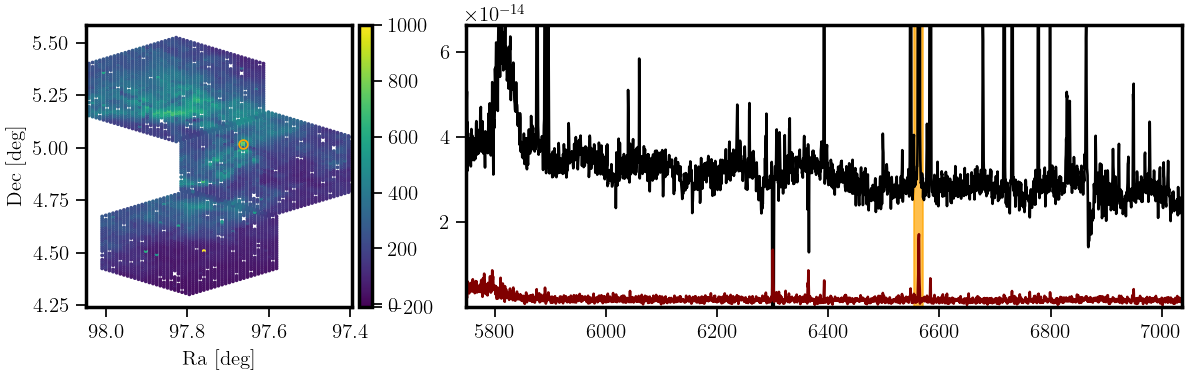

In [139]:
def add_fib(sel_fib,fib):
    sel_fib=np.append(sel_fib,fib)
    sel_fib=np.unique(sel_fib)
    return(sel_fib)
def spec_mean(data,sel_fib):
#    print(len(sel_fib))
    if (len(sel_fib)==1):
        spec=data[sel_fib,:]
        spec=spec.flatten()
    else:
        spec=np.mean(data[sel_fib,:],axis=0)
    return spec


global sp_y_min,sp_y_max,sp_x_min,sp_x_max,fib,cbar,cax0
cmap='viridis'
w0=6555
w1=6570
vmin=-10
vmax=1000
fib=int(len(tab_PT)/2)
slice_img=get_slice_img(hdu['FLUX'].data,hdu['WAVE'].data,w0,w1)
tab_map=tab_PT
tab_map['flux']=slice_img
tab_map=tab_map[tab_map['mask']==1]

list_fib=[]
list_fib.append(fib)
c_fib='orange'
c_fib_now='grey'

dw=10*(hdu['WAVE'].data[1]-hdu['WAVE'].data[0])
fsize=3.5
gamma=1
sf=1
fig = plt.figure(figsize=(9.5, 3), layout="constrained")
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

spec = fig.add_gridspec(1, 7, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.4)
ax0 = fig.add_subplot(spec[0,0:2])
ax1 = fig.add_subplot(spec[0,2:7])


sc,ax_rec,cbar,cax0=map_plot(ax0,tab_map,line='flux', \
                 vmin=vmin, vmax=vmax, title=None, filename='junk',\
             cmap=cmap, fsize=fsize, figs_dir='figs')
m_fib=ax0.plot(tab_map['ra'][fib], tab_map['dec'][fib], \
               marker="o", markersize=5, markeredgecolor=c_fib, markerfacecolor="None")

sel_fib=[]
sel_fib.append(fib)
sel_fib=np.array(sel_fib)
sel_fib = add_fib(sel_fib,fib)
sel_m_fib=[]
sel_m_fib.append(m_fib)

m_spec=spec_mean(hdu['FLUX'].data,sel_fib)
e_m_spec=spec_mean(hdu['ERROR'].data,sel_fib)


sp_y_min=-0.5*np.median(hdu['FLUX'].data[fib,:])
sp_y_max=np.max(hdu['FLUX'].data[fib,:])
sp_x_min=3550
sp_x_max=9700
sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,m_spec,e_m_spec,
                         x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
mark=ax1.fill_betweenx([sp_y_min,sp_y_max], w0, w1, color='orange',alpha=0.7)


def onclick(event):
    global sp_x_min,sp_x_max,w0,w1,ax0,ax1
    global vmin,vmax,sc,tab_map,sc,gamma,sf,cmap
    global mark,sp_y_min,sp_y_max,dw
            
    #
    # In AX1: Spec
    #
    if ((event.inaxes is ax1) & (event.xdata>ax1.get_xlim()[0]) & \
        (event.xdata<ax1.get_xlim()[1]) & \
        (event.ydata>ax1.get_ylim()[0]) & (event.ydata<ax1.get_ylim()[1])):
        if (event.button==1):
            w0=event.xdata
            if (w0>w1):
                w1=event.xdata+0.5*dw
        if (event.button==3):
            w1=event.xdata
            if (w0>w1):
                w0=event.xdata-0.5*dw
        dw=w1-w0
        try:
            mark.remove()
        except:
            mark_x=1
        mark=ax1.fill_betweenx([sp_y_min,sp_y_max], w0, w1, color='orange',alpha=0.7)
        slice_img=get_slice_img(hdu['FLUX'].data,hdu['WAVE'].data,w0,w1)
        tab_map['flux']=slice_img[tab_PT['mask']==1]                
        norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
        scat=scatter(tab_map['ra'], tab_map['dec'], ax0, size=sf*35.6/3600, \
                     c=tab_map['flux'], cmap=cmap, norm=norm)            
        sc_now=ax0.collections[0]
        sc_now.remove()
        w_range_widg.value[0]=np.round(w0,1)
        w_range_widg.value[1]=np.round(w1,1)

            

def moved_and_pressed(event):
    global sp_x_min,sp_x_max,fib,w0,w1,ax0,ax1
    global vmin,vmax,sc,tab_map,sc,gamma,sf,cmap
    global mark,sp_y_min,sp_y_max,m_fib
    global sel_fib,sel_m_fib
    global m_spec,e_m_spec
    
    if (event.button==1):    
        #act_widg.value='Mouse-B1'
        #
        # In AX0: MAP
        #
        if ((event.inaxes is ax0) & (event.xdata>ax0.get_xlim()[1]) &\
            (event.xdata<ax0.get_xlim()[0]) & \
            (event.ydata>ax0.get_ylim()[0]) & (event.ydata<ax0.get_ylim()[1])):
            dist = np.sqrt((tab_map['ra']-event.xdata)**2+(tab_map['dec']-event.ydata)**2)
            fib_now = np.argmin(dist)
            sel_fib = add_fib(sel_fib,fib_now)
            #            m_fib.pop(0).remove()
            #mark.remove()
            m_fib_now=ax0.plot(tab_map['ra'][fib_now], tab_map['dec'][fib_now], \
               marker="o", markersize=5, markeredgecolor=c_fib_now, markerfacecolor="None")
            
            sel_m_fib.append(m_fib_now)
            [l.remove() for l in ax1.lines]
            m_spec=spec_mean(hdu['FLUX'].data,sel_fib)
            e_m_spec=spec_mean(hdu['ERROR'].data,sel_fib)
            sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,m_spec,e_m_spec,
                                  x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
            #            mark.remove()
            #            mark=ax1.fill_betweenx([sp_y_min,sp_y_max], w0, w1, color='orange',alpha=0.7)
            
            
    if (event.button==3):    
        #act_widg.value='Mouse-B1'
        #
        # In AX0: MAP
        #


        if ((event.inaxes is ax0) & (event.xdata>ax0.get_xlim()[1]) &\
            (event.xdata<ax0.get_xlim()[0]) & \
            (event.ydata>ax0.get_ylim()[0]) & (event.ydata<ax0.get_ylim()[1])):
            dist = np.sqrt((tab_map['ra']-event.xdata)**2+(tab_map['dec']-event.ydata)**2)
            fib_now = np.argmin(dist)
            sel_fib = np.delete(sel_fib, np.where(sel_fib == fib_now))
            for m_fib_now in sel_m_fib:
                try:
                    m_fib_now.pop(0).remove()
                except:
                    m_fib_now_x=1

            for fib_now in sel_fib:
                m_fib_now=ax0.plot(tab_map['ra'][fib_now], tab_map['dec'][fib_now], \
                                   marker="o", markersize=5, markeredgecolor=c_fib_now, markerfacecolor="None")
                sel_m_fib.append(m_fib_now)
            try:
                m_fib.pop(0).remove()
            except:
                m_fib_x=1
            m_fib=ax0.plot(tab_map['ra'][fib], tab_map['dec'][fib], \
                           marker="o", markersize=5, markeredgecolor=c_fib, markerfacecolor="None")
            [l.remove() for l in ax1.lines]
            m_spec=spec_mean(hdu['FLUX'].data,sel_fib)
            e_m_spec=spec_mean(hdu['ERROR'].data,sel_fib)
            sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,m_spec,e_m_spec,
                                  x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
           
            
            
            
    if (event.button==2):
        #
        # In AX0: MAP
        #
        if ((event.inaxes is ax0) & (event.button==2) & (event.xdata>ax0.get_xlim()[1]) &\
            (event.xdata<ax0.get_xlim()[0]) & \
            (event.ydata>ax0.get_ylim()[0]) & (event.ydata<ax0.get_ylim()[1])):
            dist = np.sqrt((tab_map['ra']-event.xdata)**2+(tab_map['dec']-event.ydata)**2)
            fib = np.argmin(dist)
            try:
                m_fib.pop(0).remove()
            except:
                m_fib_x=1
            m_fib=ax0.plot(tab_map['ra'][fib], tab_map['dec'][fib], \
               marker="o", markersize=5, markeredgecolor=c_fib, markerfacecolor="None")
            [l.remove() for l in ax1.lines]
            m_spec=hdu['FLUX'].data[fib,:]
            e_m_spec=hdu['ERROR'].data[fib,:]            
            sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,m_spec,e_m_spec,
                                  x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
            try:
                mark.remove()
            except:
                mark_x=1
            mark=ax1.fill_betweenx([sp_y_min,sp_y_max], w0, w1, color='orange',alpha=0.7)
            tx = '%d,%.1f,%.1f' % (fib,event.xdata, event.ydata)
    
            
        #
        # In AX1: Spec
        #
        if ((event.inaxes is ax1) & (event.button==2) & (event.xdata>ax1.get_xlim()[0]) & \
            (event.xdata<ax1.get_xlim()[1]) & \
            (event.ydata>ax1.get_ylim()[0]) & (event.ydata<ax1.get_ylim()[1])):
            w0=event.xdata-0.5*dw
            w1=event.xdata+0.5*dw
            try:
                mark.remove()
            except:
                mark_x
            mark=ax1.fill_betweenx([sp_y_min,sp_y_max], w0, w1, color='orange',alpha=0.7)
            slice_img=get_slice_img(hdu['FLUX'].data,hdu['WAVE'].data,w0,w1)
            tab_map['flux']=slice_img[tab_PT['mask']==1]                
            norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
            scat=scatter(tab_map['ra'], tab_map['dec'], ax0, size=sf*35.6/3600, \
                         c=tab_map['flux'], cmap=cmap, norm=norm)            
            sc_now=ax0.collections[0]
            sc_now.remove()
            w_range_widg.value[0]=np.round(w0,1)
            w_range_widg.value[1]=np.round(w1,1)
            #act_widg.value=f'1fib:{len(fib)}'

            

def w_update(change):
    global w0,w1
    w0=change.new[0]
    w1=change.new[1]
    map_update()

def w0_update(change):
    global w0
    w0=change.new
    map_update()
    
    
def cmap_update(change):
    global cmap
    cmap=change.new
    map_update()

def w1_update(change):
    global w1
    w1=change.new
    map_update()
    
def update_flux(change):
    global vmin,vmax
    vmin=change.new[0]
    vmax=change.new[1]
    map_update()
    
def map_update():
    global sp_x_min,sp_x_max,w0,w1,ax0,ax1
    global vmin,vmax,sc,tab_map,sc,gamma,sf,cmap
    global mark,cbar,cax0,scat
    global sp_y_min,sp_y_max,fib,mark
    global m_spec,e_m_spec
    [l.remove() for l in ax1.lines]
    sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,m_spec,e_m_spec,
                         x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)    
    mark.remove()
    mark=ax1.fill_betweenx([sp_y_min,sp_y_max], w0, w1, color='orange',alpha=0.7)
    slice_img=get_slice_img(hdu['FLUX'].data,hdu['WAVE'].data,w0,w1)
    tab_map['flux']=slice_img[tab_PT['mask']==1]                
    norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
    scat=scatter(tab_map['ra'], tab_map['dec'], ax0, size=sf*35.6/3600, \
                 c=tab_map['flux'], cmap=cmap, norm=norm)            
    sc_now=ax0.collections[0]
    sc_now.remove()
    cbar = plt.colorbar(scat.sc, cax=cax0)#,fontsize=21)
    w_range_widg.value=(np.round(w0,1),np.round(w1,1))
    
    
def update_spec_range(change):
    global sp_x_min,sp_x_max,sp_y_min,sp_y_max,fib,mark
    global m_spec,e_m_spec
    sp_x_min=change.new[0]
    sp_x_max=change.new[1]
    [l.remove() for l in ax1.lines]
    sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,m_spec,e_m_spec,
                         x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
    text.set_x(ax1.get_xlim()[0]+0.025*(ax1.get_xlim()[1]-ax1.get_xlim()[0]))
    text.set_y(ax1.get_ylim()[1]-0.1*(ax1.get_ylim()[1]-ax1.get_ylim()[0]))
        
def update_spec_yrange(change):
    global sp_x_min,sp_x_max,sp_y_min,sp_y_max,fib,mark
    global m_spec,e_m_spec
    sp_y_min=change.new[0]/1e13
    sp_y_max=change.new[1]/1e13
    [l.remove() for l in ax1.lines]
    sp_p,e_sp_p=spec_plot(ax1,hdu['WAVE'].data,m_spec,e_m_spec,
                         x_min=sp_x_min,x_max=sp_x_max,y_min=sp_y_min,y_max=sp_y_max)
    text.set_x(ax1.get_xlim()[0]+0.025*(ax1.get_xlim()[1]-ax1.get_xlim()[0]))
    text.set_y(ax1.get_ylim()[1]-0.1*(ax1.get_ylim()[1]-ax1.get_ylim()[0]))    
    
    
int_range_xspec = widgets.FloatRangeSlider(
    value=(sp_x_min,sp_x_max), 
    min=sp_x_min, max=sp_x_max, step=hdu['WAVE'].data[1]-hdu['WAVE'].data[0], 
    description='Spec. Wave Range',layout=widgets.Layout(width='85%')
)

int_range_yspec = widgets.FloatRangeSlider(
    value=(sp_y_min*1e13,sp_y_max*1e13), 
    min=sp_y_min*1e13, max=sp_y_max*1e13, step=1e13*(sp_y_max-sp_y_min)/1000, 
    description='Spec. Flux Range',layout=widgets.Layout(width='85%')
)


int_range_flux = widgets.FloatRangeSlider(
    value=(vmin,vmax), 
    min=vmin, max=vmax, step=(vmax-vmin)/100,
    description='Flux Range',layout=widgets.Layout(width='90%')
)

w_range_widg = widgets.FloatRangeSlider(
    value=(w0,w1), 
    min=sp_x_min, max=sp_x_max, step=hdu['WAVE'].data[1]-hdu['WAVE'].data[0], 
    description='Wave Map',layout=widgets.Layout(width='95%')
)


act_widg=widgets.Text(
    value='None',
    description='Action:',
    disabled=False,layout=widgets.Layout(width='60%')#,margin='0 0 0 0')
)


cmap_widg=widgets.Dropdown(
    options=plt.colormaps(),
    value=cmap,
    description='cmap:',
    disabled=False,layout=widgets.Layout(width='30%')
)



int_range_xspec.observe(update_spec_range, 'value')
int_range_yspec.observe(update_spec_yrange, 'value')
int_range_flux.observe(update_flux, 'value')
w_range_widg.observe(w_update, 'value')
cmap_widg.observe(cmap_update,'value')

cid_click = fig.canvas.mpl_connect('button_press_event', onclick)
cid_hold = fig.canvas.mpl_connect('motion_notify_event', moved_and_pressed)



UBox = widgets.HBox([w_range_widg],layout=widgets.Layout(width='100%',margin='0 0 0 0', align_items = 'stretch'))
LBox = widgets.VBox([int_range_xspec,int_range_yspec],layout=widgets.Layout(width='60%',margin='0 0 0 0'))
MBox = widgets.HBox([cmap_widg,act_widg])
RBox =  widgets.VBox([int_range_flux,MBox],layout=widgets.Layout(width='60%',margin='0 0 0 0', align_items = 'stretch'))

DBox=widgets.HBox([RBox,LBox])
widgets.VBox([UBox,DBox])


In [140]:
#tab_map.columns